# JQA Subject-Topic Prediction

1. [Data Preparation](#prep)
2. [Training & Normalizing](#training)
3. [Class Balancing - Subject Distribution](#distribution)
4. [Model Testing](#testing)
5. [Pipeline - Model Training](#pipeline)
6. [GridSearch - Model Tuning](#gridsearch)

Imbalanced Classification Problem.

In [20]:
# Import necessary libraries.
import re, nltk, warnings, csv, sys, os, pickle, string
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from scipy import stats
import matplotlib.pyplot as plt

# Import NLTK packages.
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Import sklearn packages.
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Library for class imbalance.
from imblearn.under_sampling import RandomUnderSampler

# Import and append stopwords.
stop_words = stopwords.words("english")
stop_words.append('mr')

# Ignore warnings related to deprecated functions.
warnings.filterwarnings('ignore')

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

# Read in file; select columns; drop rows with NA values (entries without a named person).
df = pd.read_csv(abs_dir + 'Data/Output/ParsedXML/JQA_Subjects-dataframe.txt',
                 sep = '\t') \
    .drop(columns = ['file']) \
    .dropna()

df.head()

,entry,date,subject,text
0,jqadiaries-v30-1817-10-01,1817-10-01,"Adams Family Residences,Commerce",1. IV:30. Wednesday. Wrote a Letter to J. L. S...
1,jqadiaries-v30-1817-10-02,1817-10-02,"Foreign Relations,Health and Illness,South Ame...",2. IV: Continued drafting instructions for Rus...
2,jqadiaries-v30-1817-10-03,1817-10-03,"Adams Family Residences,Privateering,Recreatio...",3. IV: I had visits this morning from Mr Levet...
3,jqadiaries-v30-1817-10-04,1817-10-04,"Commerce,Foreign Relations,Health and Illness",4. IV: I waked before three and had afterwards...
4,jqadiaries-v30-1817-10-05,1817-10-05,Adams Family Residences,5. V: The Ladies went this morning to St. John...


<a id='prep'/>

## Clean & Prepare Data

In [21]:
%%time

# Create id column for subsetting.
df['cid'] = df.index

# Lowercase text field
df['text'] = df['text'].str.lower()

# Tokenize text field.
df['text'] = df['text'].apply(word_tokenize)

# Lemmatize and stem text field.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english", ignore_stopwords = True)

def lemma_and_stem(list_of_words):
    return [stemmer.stem(lemmatizer.lemmatize(w)) for w in list_of_words if w not in stop_words]

df['text'] = df['text'].apply(lemma_and_stem)

# Convert list of words to string for LDA model.
df['text'] = df['text'].apply(' '.join)

# Light regex cleanup to remove JQA's initial numbering (&, eventually, roman numeral sequencing).
df['text'] = df['text'].str.replace(r'^\d+.', '', regex = True)

# Unnest subject headings. 
df['subject'] = df['subject'].str.split(',')
df = df.explode('subject')

# Remove leading and trailing whitespace.
df['subject'] = df['subject'].str.strip()

# Remove rows with subject of "The".
df = df[~df['subject'].isin(['The'])]

print (f'Number of unique subject headings: {len(df["subject"].unique())}\nDF Shape: {df.shape}')

df.head()

Number of unique subject headings: 70
DF Shape: (5913, 5)
CPU times: user 14.5 s, sys: 73 ms, total: 14.6 s
Wall time: 14.8 s


,entry,date,subject,text,cid
0,jqadiaries-v30-1817-10-01,1817-10-01,Adams Family Residences,iv:30. wednesday . wrote letter j. l. sulliva...,0
0,jqadiaries-v30-1817-10-01,1817-10-01,Commerce,iv:30. wednesday . wrote letter j. l. sulliva...,0
1,jqadiaries-v30-1817-10-02,1817-10-02,Foreign Relations,iv : continu draft instruct rush . subject op...,1
1,jqadiaries-v30-1817-10-02,1817-10-02,Health and Illness,iv : continu draft instruct rush . subject op...,1
1,jqadiaries-v30-1817-10-02,1817-10-02,South American Wars of Independence,iv : continu draft instruct rush . subject op...,1


### Visualize Single-Subject vs. Multiple-Subjects Distribution

The classificiation model was unable to predict subjects with duplicates (multi-subject documents). Removing documents with multiple-subjects might improve the model training.

* How much of the data is lost if mult-subjects removed?
* Do some subj only appear in multi-subj lists (and, therefore, disproportionately affected)?

In [22]:
%%time

# Count dates, which indicate if there are multiple subjects or not.
# idx_count = pd.DataFrame(df.groupby(['date']).size()).reset_index()
idx_count = df[['cid', 'subject']]

idx_count = pd.DataFrame(idx_count.groupby(['cid']).size()).reset_index()
idx_count.columns = ['cid', 'count']

idx_count = idx_count.query('count > 1')
remove_list = idx_count['cid']

print (f'Removing {len(remove_list)} rows.')

df = df[~df['cid'].isin(remove_list)]
print (f'New DF Shape (after removing mutli-subject docs): {df.shape}')

# print ('Number of topics removed after pruning multi-subject documents:')
# df[df['cid'].isin(remove_list)]['subject'].value_counts()

Removing 1490 rows.
New DF Shape (after removing mutli-subject docs): (813, 5)
CPU times: user 7.65 ms, sys: 1.71 ms, total: 9.36 ms
Wall time: 7.84 ms


<a id='training'/>

## Train Model

CPU times: user 35.9 ms, sys: 2.13 ms, total: 38 ms
Wall time: 37.2 ms


Text(199.09323493234933, 277.83, 'Mean: 180.99')

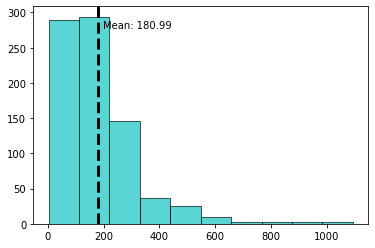

In [23]:
%%time

# Drop duplicate texts (created from unnested subject headings) & count words.
doc_len = df['text'].str.split(' ').str.len() \
    .reset_index() \
    .drop_duplicates()

doc_len = pd.DataFrame(doc_len)

x = doc_len['text']

# Plot graph.
ax = plt.hist(x, bins = 10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color = 'k', linestyle = 'dashed', linewidth = 3)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

### Normalize Document Length & Train Model

In [24]:
%%time

def splitText(string):
    words = string.split()
    grouped_words = [' '.join(words[i: i + 200]) for i in range(0, len(words), 200)]
    return grouped_words

df['text'] = df['text'].apply(splitText)

df = df.explode('text')

# Count words and remove short strings.
df['count'] = df['text'].str.split().str.len()
df = df[~(df['count'] < 50)]

print (f'New Average Length of Docs: {df["count"].mean()}')

# Remove duplicate text rows (caused from unnesting headings) by subsetting & de-duplicating.
topics = df[['cid', 'text']]

# Initialise the vectorizer with English stop words.
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed texts.
features = vectorizer.fit_transform(topics['text'])

# Helper function (from Kapadia).
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Set parameters (topics set to number of unique subject headings found).
number_topics = 20
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components = number_topics, n_jobs=-1)
lda.fit(features)

# Create a document-topic matrix.
dtm = lda.transform(features)

# Convert document-topic matrix to dataframe.
dtm = pd.DataFrame(dtm, index = topics.index)

# Join document-topic dataframe with metadata on shared indices.
dtm = pd.merge(df[['entry', 'date', 'subject']],
               dtm,
               left_index = True, right_index = True)

dtm.head(3)

New Average Length of Docs: 148.32881002087683
CPU times: user 604 ms, sys: 248 ms, total: 852 ms
Wall time: 3.36 s


,entry,date,subject,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
4,jqadiaries-v30-1817-10-05,1817-10-05,Adams Family Residences,0.000820,0.000820,0.888066,0.000820,0.000820,0.000820,0.000820,...,0.000820,0.097180,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820
12,jqadiaries-v30-1817-10-13,1817-10-13,Adams Family Residences,0.001163,0.001163,0.001163,0.001163,0.001163,0.001163,0.001163,...,0.001163,0.001163,0.001163,0.001163,0.001163,0.001163,0.509863,0.001163,0.001163,0.001163
18,jqadiaries-v30-1817-10-19,1817-10-19,Health and Illness,0.000820,0.000820,0.000820,0.000820,0.984426,0.000820,0.000820,...,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820


<a id='distribution'/>

## Distribution of Subjects

There is a class imbalance of subject headings: some subjects used far more frequently then others. This will require either under-sampling the larger classes (preferable at the moment) or over-sampling the small classes.

Range: 263
Min: 1, Max: 264
CPU times: user 126 ms, sys: 4.93 ms, total: 131 ms
Wall time: 130 ms


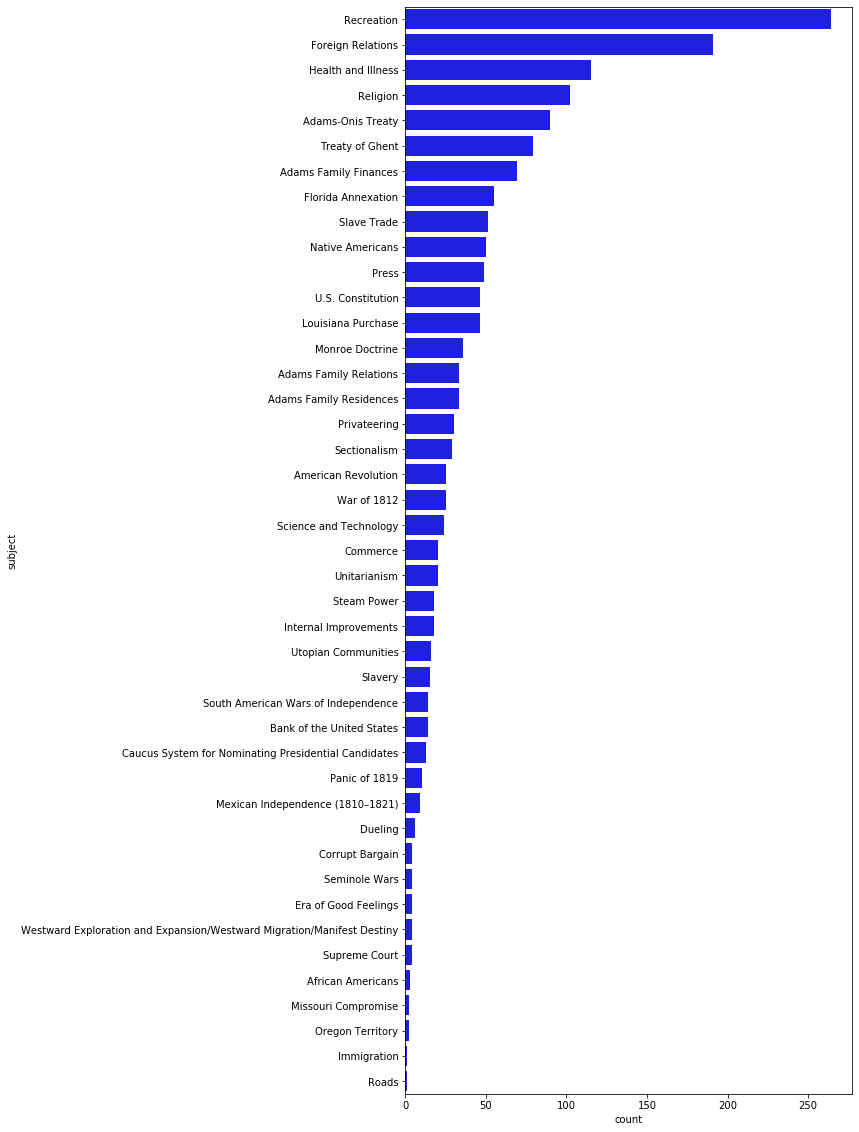

In [25]:
%%time

fig, ax = plt.subplots(figsize = (8, 20))

subj = pd.DataFrame(dtm['subject'].value_counts()).reset_index()

subj.columns = ['subject', 'count']

print ('Range:', np.ptp(subj['count']))
print (f'Min: {subj["count"].min()}, Max: {subj["count"].max()}')

sns.barplot(data = subj.sort_values(by = ['count'], ascending = False), 
            x = 'count', y = 'subject', color = 'b')

CPU times: user 91.3 ms, sys: 3.47 ms, total: 94.8 ms
Wall time: 93.9 ms


<Figure size 864x576 with 0 Axes>

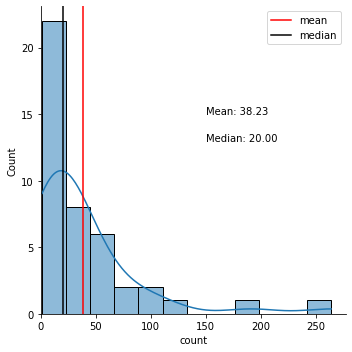

In [28]:
%%time

plt.figure(figsize = (12, 8))

ax = sns.displot(subj["count"], kde = True)
plt.xlim(0)

plt.axvline(np.mean(subj["count"]), color = 'r', label = 'mean')
plt.axvline(np.median(subj["count"]), color = 'k', label = 'median')

plt.text(150, 15, 'Mean: {:.2f}'.format(subj["count"].mean()))
plt.text(150, 13, 'Median: {:.2f}'.format(subj["count"].median()))

plt.legend()

### Undersample Over-represented Subjects

In [29]:
%%time


# Filter out rows with infrequently occuring subject headings.
remove_list = subj.query('count < 15')['subject'].tolist()

dtm = dtm[~dtm['subject'].isin(remove_list)]
dtm.shape

# Balance subjects (classes) by undersampling over-represented subjects.
sampler = RandomUnderSampler(random_state = 0)

data = dtm.drop(columns = ['entry', 'date'])

X = data.iloc[:, 1:] # Select features.
y = data['subject'] # Select predictor (target).

data, y_res = sampler.fit_resample(X, y)

# dropped_ids = [i for i in range(X.shape[0]) if i not in sampler.sample_indices_]
# X.iloc[dropped_ids]  # for dataframes

data['subject'] = y_res

# Visualize new balance.
sampled_subj = pd.DataFrame(data['subject'].value_counts()).reset_index()
print (f'Sample shape: {sampled_subj.shape}')

sampled_subj.columns = ['subject', 'count']

print (f'\nBalanced Classes: \n\tMinimum Subject: {sampled_subj["count"].min()}\n\tMaximum Subject: {sampled_subj["count"].max()}')

Sample shape: (27, 2)

Balanced Classes: 
	Minimum Subject: 15
	Maximum Subject: 15
CPU times: user 20.7 ms, sys: 2.24 ms, total: 22.9 ms
Wall time: 21.3 ms


## Prediction

Do topics accurately predict subject headings (linear regression).

* Start with docs with single subject, then introduce multi-subject docs

<a id='testing'/>

## Test Models

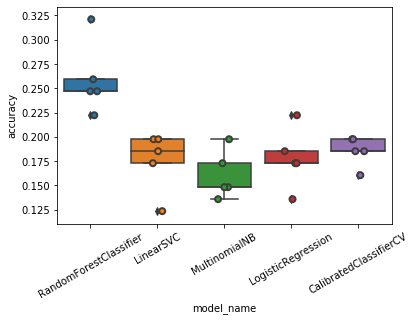

CPU times: user 4.16 s, sys: 41.4 ms, total: 4.2 s
Wall time: 2.75 s


model_name
CalibratedClassifierCV    0.185185
LinearSVC                 0.175309
LogisticRegression        0.177778
MultinomialNB             0.160494
RandomForestClassifier    0.259259
Name: accuracy, dtype: float64

In [30]:
%%time

X = data.iloc[:, :-1] # Select features.
y = data['subject'] # Select predictor (target).

# Declare models to evaluate.
models = [
    RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state = 0),
    CalibratedClassifierCV(base_estimator = LinearSVC())
]

# Set up cross validation.
CV = 5

cv_df = pd.DataFrame(index = range(CV * len(models)))

# Measure accuracy of models and create dataframe of results.
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring = 'accuracy', cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_idx', 'accuracy'])

# Visualize model accuracy.
sns.boxplot(x = 'model_name', y = 'accuracy', data = cv_df)
sns.stripplot(x = 'model_name', y = 'accuracy', data = cv_df, 
              size = 6, jitter = True, edgecolor = "gray", linewidth = 2)

plt.xticks(rotation = 30)
plt.show()

# Print accuracy report.
cv_df.groupby('model_name').accuracy.mean()

<a id='pipeline'/>

## Train Model with Pipeline

In [ ]:
%%time

X = data.iloc[:, :-1] # Select features.
y = data['subject'] # Select predictor (target).

# Split data into training & testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y)

# Transformers
numeric_transformer = Pipeline( steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline( steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('onehot', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'))
])

cat_features = data.select_dtypes(include = ['object', 'bool']).columns
num_features = data.select_dtypes(include = ['int64', 'float64']).columns

# Apply transformers.
preprocessor = ColumnTransformer( transformers = [
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, selector(dtype_include = 'category'))
])

# Assemble pipeline.
pipe = Pipeline( steps = [
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 0))
])

# Instantiate cross validation.
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

scores = cross_val_score(pipe, X, y, cv = cv, n_jobs = -1)
print ("Cross Validation Accuracy: ", round(scores.mean() * 100, 2), '%')

# Cross check with another method.
pipe.fit(X_train, y_train)
print ('Model score: %.3f\n' % pipe.score(X_test, y_test))

<a id = 'gridsearch'/>

## GridSeachCV for Model Tuning

In [ ]:
%%time

param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy']
}


cv = GridSearchCV(pipe, param_grid, n_jobs= -1)                
cv.fit(X_train, y_train)

print(f'Best Parameters: {cv.best_params_}')
print(f'\nBest Score: {cv.best_score_}')